# Algorithmik: Praktikum 3 - Algorithmus von Dijkstra
In diesem Notebook werden Sie Dijkstras Suchalgorithmus auf ein Straßennetz in Gummersbach anwenden. Dabei haben Sie die Möglichkeit, Ihren kürzesten Weg mit dem kürzesten Weg der Mapping-Bibliothek von [OpenStreetMap](https://www.openstreetmap.de/) zu vergleichen.

Für die meisten Übungen finden Sie hier eine bestehende Struktur. Sie dürfen jedoch gerne, von dieser Struktur abweichen, wenn Sie denken, dass es einen besseren, effizienteren Weg gibt, das Problem zu lösen. Starten Sie das Jupyter Notebook, um zu beginnen!

Dieses Praktikum gibt Ihnen die Möglichkeit, Ihr Wissen, das Sie in der [Vorlesung zum Thema Graphen](https://ilias.th-koeln.de/goto.php?target=file_2370197_download&client_id=ILIAS_FH_Koeln) erworben haben, zu festigen, indem Sie praktische Erfahrungen mit echten Kartendaten sammeln.

Sie werden hierbei auf die [OSMNX-Bibliothek] (https://osmnx.readthedocs.io/en/stable/) zurückgreifen, um Python-Grafiken aus OpenStreetMap (OSM)-Daten zu erzeugen. Der Link führt Sie zur Dokumentation, die Ihnen beim Verständnis nützlich seien könnte. Im folgenden Abschnitt finden Sie den Import für empfohlene Bibliotheken, die Ihnen beim Absolvieren der Aufgabe behilflich seien könnten. Diese sind jedoch nicht verpflichtend und Sie dürfen auch weitere Bibliotheken einbinden.

In [1]:
import osmnx as ox
import numpy as np
import queue
import math
import priority_dict
from visualization import plot_path
import sys

Nachdem Sie den Code bis einschließlich der unten stehenden Zellen ausgeführt haben, sollten Sie die Ausgabe des kürzesten Weges zwischen den beiden Punkten sehen. Ihr Ziel ist es, dieselbe Ausgabe zu erhalten, wenn Sie Dijkstras Suchalgorithmus implementieren.

In [2]:
map_graph = ox.graph.graph_from_address('Gummersbach, Steinmüllerallee 1, Germany', dist=5000, network_type='bike')

In [3]:
# Breiten- und Längengrad
origin_point = (50.985108, 7.542490)
destination_point = (51.022255, 7.562705) #Das Ziel, der Campus Gummersbach

origin = ox.distance.nearest_nodes(map_graph, origin_point[1], origin_point[0])
destination = ox.distance.nearest_nodes(map_graph, destination_point[1], destination_point[0])

In [4]:
print(origin)
print(destination)

5827857288
5969466843


In [5]:
shortest_path = ox.distance.shortest_path(map_graph, origin, destination, weight='length')

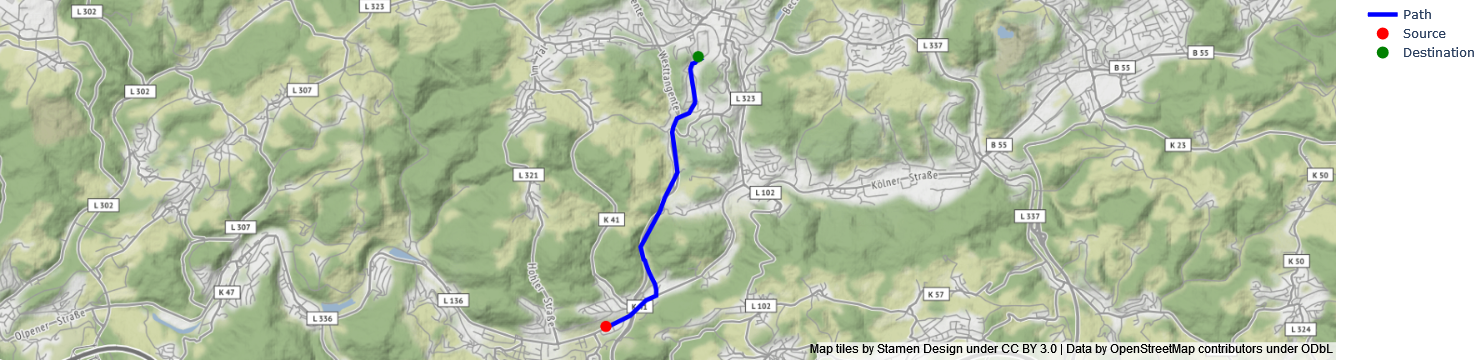

In [6]:
plot_path(map_graph, shortest_path, origin_point, destination_point)

## Algorithmus von Dijkstra
Betrachten wir Dijkstra-Algorithmus. Zur Auffrischung haben wir hier den Pseudocode aus der Vorlesung zum Thema Graphen eingefügt (evtl. wollen Sie sich auch noch mal Seite 117 des Foliensatzes anschauen).

![Dijkstra's Pseudocode](dijkstra.png)

Diese Funktion soll von Ihnen unten in `dijkstras_search()` implementiert werden. Wir haben eine Hilfsfunktion `get_path()` eingebaut, die dabei hilft, den Pfad aus dem dictionary der Vorgänger abzurufen, sobald das Ziel gefunden wurde.

Um die Dijkstra-Suche durchzuführen, benötigen wir eine priority queue (oder einen Min-Heap), die in der Klasse `priority_dict` bereits implementiert ist. Auf diese Klasse wird wie auf ein normales dictionary zugegriffen, mit dem Unterschied, dass die keys dieses dictionary nach ihrem value sortiert werden. Wir können die Knoten (vertices/nodes) als keys für unsere priority queue (Prioritätswarteschlange) verwenden und ihre Distanz vom Startpunkt (origin) als ihren value.

Um zum Beispiel die Distanz eines Knotens `v` auf den Wert der Variable `dist` zu setzen, können wir `open_queue[v] = dist` einsetzen. Um den kleinsten value in der priority queue zu erhalten, können wir `priority_dict.pop_smallest()` verwenden. Der Aufruf gibt ein Tupel mit dem Schlüssel des Knotens und seiner Entfernung vom Startpunkt zurück.

Die primäre Eingabe für die Suche ist der `graph` den Sie traversieren. Dies ist eine OSMNX Repräsentation des Straßennetzwerks. Die Knoten werden dabei als keys betrachtet mit `origin_key` und `goal_key` als Start- und Endknoten Ihrer Suche nach dem kürzesten Pfad. Um auf die ausgehenden Kanten (edges) zugreifen zu können, können wir `graph.out_edges([u], data=True)` nutzen. Der Rückgabewert ist eine Liste von Tupeln, von denen jedes eine ausgehende Kante darstellt. Das zweite Element eines jeden Tupels ist der ausgehende Knoten am anderen Ende der Kante. Sie können über diese Liste von Tupeln iterieren, indem Sie wie folgt iterieren:

`for edge in graph.out_edges([u], data=True):`

Auf den ausgehenden Knoten können Sie zugreifen indem Sie auf das 2. Element des Tupels zugreifen:

`edge[1]`.

Um das Kantengewicht dieser Kante zu erhalten, können Sie auf das 3. Element in diesem Tupel zugreifen:

`length = edge[2]['length']`.

Ihre Aufgabe ist es nun den kürzesten Weg im Graphen zu finden, ausgehend vom Ursprung (origin) zum Ziel (destination). Hierbei verwenden Sie den Algorithmus von Dijkstra. Denken Sie daran, die priority queue einzusetzen, um den optimalen Vorgänger zu speichern, damit Sie, so Sie das Ziel gefunden haben, auf den kürzesten Pfad zurückgreifen können.


In [7]:
def dijkstras_search(origin_key, goal_key, graph):
    """
    Finden des kürzesten Weges durch Einsatz des Dijkstra Algorithmus.

    Param:
    -----

    origin_key = Start Knoten
    goal_key = Zielpunkt
    graph = OpenStreetMap Graph

    Return:
    ------
    kürzester Pfad zum Ziel

    """
    known = set()
    predecessors = dict()
    perimeter = priority_dict.priority_dict()

    for node in graph:
        perimeter[node] = sys.maxsize
        predecessors[node] = None

    perimeter[origin_key] = 0

    while perimeter:
        current_key, current_distance = perimeter.pop_smallest()
        known.add(current_key)

        for edge in graph.out_edges([current_key], data=True):
            neighbor_key = edge[1]
            distance_from_current_to_neighbor = edge[2]['length']

            if neighbor_key in known:
                continue

            old_distance_to_neighbor = perimeter[neighbor_key]
            new_distance_to_neighbor = current_distance + distance_from_current_to_neighbor

            if new_distance_to_neighbor < old_distance_to_neighbor:
                perimeter[neighbor_key] = new_distance_to_neighbor
                predecessors[neighbor_key] = current_key

    return get_path(origin_key, goal_key, predecessors)




    #return get_path(origin_key, goal_key, predecessors)

In [8]:
# This function follows the predecessor
# backpointers and generates the equivalent path from the
# origin as a list of vertex keys.
def get_path(origin_key, goal_key, predecessors):
    key = goal_key
    path = [goal_key]

    while key != origin_key:
        key = predecessors[key]
        path.insert(0, key)

    return path

Nachdem Sie diese beiden Funktionen implementiert haben, führen Sie die unten stehende Zelle aus, um zu sehen, ob Ihre Ausgabe mit der obigen OSMNX Funktion übereinstimmt. Ist dies nicht der Fall, haben Sie einen Fehler bei Ihrer Implementierung gemacht.

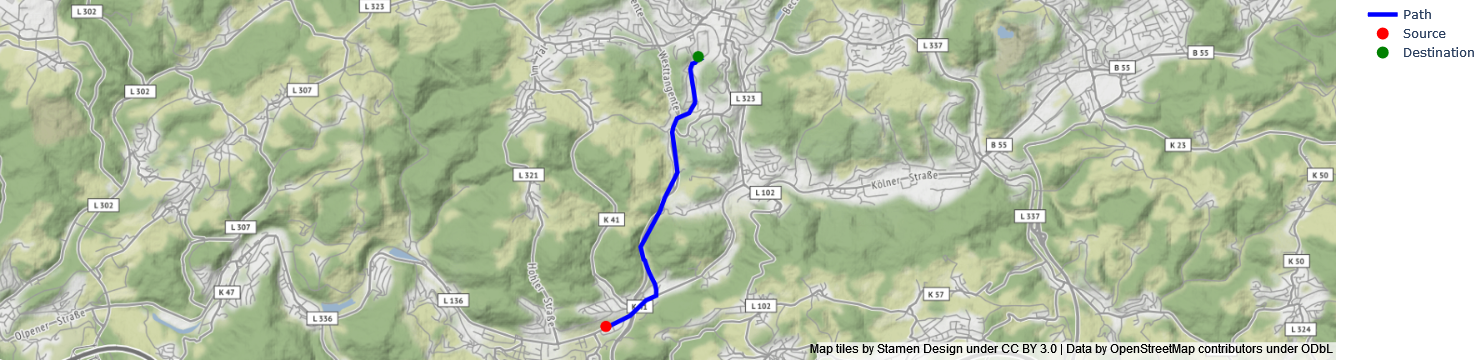

In [9]:
path = dijkstras_search(origin, destination, map_graph)
plot_path(map_graph, path, origin_point, destination_point)